### Prediction of Fazekas/clinical scores from uncertainty

using the methodology I employed for ADNI, which uses a different data loading pipeline.

In [1]:
# trainer
print("strawberry")
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# data
from trustworthai.utils.data_preprep.dataset_pipelines import load_clinscores_data, load_data, ClinScoreDataRetriever
from torch.utils.data import ConcatDataset, Dataset, DataLoader
from trustworthai.utils.data_preprep.splits import cross_validate_split

# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
from tqdm import tqdm
from collections import defaultdict
from natsort import natsorted
import torchmetrics
from torchsampler import ImbalancedDatasetSampler
print("banana")

strawberry



KeyboardInterrupt



In [ ]:
### load the data
# using a new seed!
clin_retriever = ClinScoreDataRetriever(use_updated_scores=True)


In [ ]:
split = 0
train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
        combine_all=False,
        test_proportion=0.13, 
        validation_proportion=0.13,
        seed=5,
        cross_validate=True,
        cv_split=split,
        cv_test_fold_smooth=1,

    )

In [ ]:
len(train_ds_clin), len(val_ds_clin) + len(test_ds_clin)

In [ ]:
labs = []
for data in train_ds_clin:
    labs.append(data[2]['PVWMH'])
for data in val_ds_clin:
    labs.append(data[2]['PVWMH'])
for data in test_ds_clin:
    labs.append(data[2]['PVWMH'])

In [ ]:
(torch.Tensor(labs) == 3).sum()

In [ ]:
class CustomClinFieldsDataset(torch.utils.data.Dataset):
    # this is just a wrapper on the clinical dataset where I am hard coding a few things, such as one hot encodings, and all the other stuff that
    # I might want to compute like tab fazekas and total fazekas etc
    def __init__(self, base_dataset):
        super().__init__()
        self.base_dataset = base_dataset
        
    def __getitem__(self, idx):
        x, y, clin_data = self.base_dataset[idx]
        r = clin_data.copy()
        
        # smoking
        r['smoking_0'] = (r['smoking'] == 0).astype(np.float32)
        r['smoking_1'] = (r['smoking'] == 1).astype(np.float32)
        r['smoking_2'] = (r['smoking'] == 2).astype(np.float32)
        
        # total fazekas and scale fazekas
        dwmh = r['DWMH']
        pvwmh = r['PVWMH']
        total_fazekas = np.nan
        if (not np.isnan(dwmh)) and (not np.isnan(pvwmh)):
            total_fazekas = dwmh + pvwmh
        r['total_fazekas'] = total_fazekas
        r['scale_fazekas'] = ((pvwmh == 3) | (dwmh > 1)).astype(np.float32)
        
        # scale PVS
        bgpvs = r['BGPVS']
        scale_pvs = np.nan
        if not np.isnan(bgpvs):
            scale_pvs = (bgpvs >= 2).astype(np.float32)
        r['scale_pvs'] = scale_pvs
        
        # scale micrBld
        micrbld = r['micrBld']
        scale_micrbld = np.nan
        if not np.isnan(scale_micrbld):
            scale_micrbld = (micrbld > 0).astype(np.float32)
        r['scale_micrbld'] = scale_micrbld
        
        # stroke_les and scale stroke
        oldLes = r['oldLes']
        relLes = r['relLes']
        stroke_les = np.nan
        scale_stroke = np.nan
        if not np.isnan(oldLes):
            if type(relLes) == str:
                if relLes != ' ':
                    relLes = float(relLes)
                else:
                    relLes = 0.0
            if type(oldLes) == str:
                if oldLes != ' ':
                    oldLes = float(oldLes)
                else:
                    oldLes = 0.0
            try:
                if np.isnan(relLes):
                    relLes = 0.0
            except:
                print("failed on : ", relLes, type(relLes))
            
            try:
                stroke_les = ((oldLes ==1)| (relLes==1)).astype(np.float32)
            except:
                print(f"failed: old:{oldLes}, rel:{relLes}")
            scale_stroke = (oldLes * relLes).astype(np.float32)
        r['stroke_les'] = stroke_les
        r['scale_stroke'] = scale_stroke
            
        return x, y, r
    
    def __len__(self):
        return len(self.base_dataset)

In [ ]:
### load the extra information (e.g uncertainty maps, var maps, preds etc)
umap_model_name = "SSN_Ens_Mean"
output_maps_dir = f"/home/s2208943/ipdis/data/preprocessed_data/EdData_output_maps/{umap_model_name}/"

output_maps_files = os.listdir(output_maps_dir)

In [ ]:
#output_maps_files

In [ ]:
def get_output_maps_for_ds(ds):
    output_maps_lists = defaultdict(lambda : [])
    for data in tqdm(ds, position=0, leave=True):
        ID = data[2]['ID']
        output_maps_data = np.load(f"{output_maps_dir}{ID}_out_maps.npz")
        for output_type in output_maps_data.keys():
            output_maps_lists[output_type].append(torch.from_numpy(output_maps_data[output_type]))
            
    return output_maps_lists

In [ ]:
### dataset to load in the uncertainty maps and prediction data and add it into the existing dataset.

class AddChannelsDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, extra_x_channels_lists):
        self.base_dataset = base_dataset
        self.extra_x_channels_lists = extra_x_channels_lists
        
    def __getitem__(self, idx):
        data = self.base_dataset[idx]
        x = data[0]
        x = torch.cat([x, *[self.extra_x_channels_lists[key][idx].unsqueeze(0) for key in natsorted(self.extra_x_channels_lists.keys())]], dim=0)
        
        return (x, *data[1:])
        
    def __len__(self):
        return len(self.base_dataset)

In [ ]:
### defining the augmentation procedure
from trustworthai.utils.augmentation.standard_transforms import (
    RandomFlip, GaussianBlur, GaussianNoise,
    RandomResizeCrop, RandomAffine,
    NormalizeImg, PairedCompose, LabelSelect,
    PairedCentreCrop, CropZDim,
)
import torch


def get_transforms():
    transforms = [
        LabelSelect(label_id=1),
        RandomFlip(p=0.5, orientation="horizontal"),
        # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        # GaussianNoise(p=0.2, mean=0, sigma=0.2),
        RandomAffine(p=0.2, shear=(-18,18)),
        RandomAffine(p=0.2, degrees=15),
        RandomAffine(p=0.2, translate=(-0.1,0.1)),
        RandomAffine(p=0.2, scale=(0.9, 1.1)),
#         #RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))

#         #RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.)) # ssn
    ]
    transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
    return PairedCompose(transforms)

In [ ]:
### combine the clinical scores data into the x information.
# generated with chatgpt
class ClinicalDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, fields, target_field):
        self.base_dataset = base_dataset
        self.fields = fields
        self.target_field = target_field

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, index):
        x, y, clin_data = self.base_dataset[index]
        clin_data_fields = clin_data[self.fields].values
        clin_data_tensor = torch.from_numpy(clin_data_fields.astype(np.float32))
        target_field = clin_data[self.target_field]
        return (x, clin_data_tensor), target_field

In [ ]:
# torch dataset that filters out nans
class NonNanDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        self.indices = []

        for i in range(len(self.original_dataset)):
            (x, clin_data), y = self.original_dataset[i]
            if not (np.isnan(y) or torch.any(torch.isnan(clin_data))):
                self.indices.append(i)

    def __getitem__(self, index):
        original_index = self.indices[index]
        return self.original_dataset[original_index]

    def __len__(self):
        return len(self.indices)


In [ ]:
class GetLabelsDs(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        
    def __getitem__(self, idx):
        return self.base_dataset[idx]
    
    def __len__(self):
        return len(self.base_dataset)
    
    def get_labels(self):
        labels = []
        for (x, clin_data), y in self.base_dataset:
            labels.append(y)
            
        return labels

In [ ]:
class AugmentedDataset_CVD(Dataset):
    def __init__(self, base_dataset, transforms):
        self.base_dataset = base_dataset
        self.transforms = transforms
        
    def __getitem__(self, idx):
        (x, clin_data), label = self.base_dataset[idx]
        if self.transforms:
            return (*self.transforms(x[[0, 2, 3, 4, 5, 6]], x[1]), clin_data), label # x[1] is just the mask
        else:
            return (x[[0, 2, 3, 4, 5, 6]], x[1], clin_data), label
    
    def __len__(self):
        return len(self.base_dataset)

In [ ]:
### building the combined datasets with 
# augmentation transforms, added in umaps and predictions as channels
# and code to select 3 slices from the image.

def build_clinscores_prediction_dataset(ds, clin_fields=['age'], target_field='DWMH', apply_augmentation=True):
    
    # sort out the extra fields I need (e.g smoking one hot encoded)
    ds = CustomClinFieldsDataset(ds)
    
    # load in the extra data (e.g umaps) to build a combined dataset
    print("loading umaps and wmh preds images")
    output_maps_test = get_output_maps_for_ds(ds)
    new_ds = AddChannelsDataset(ds, output_maps_test)
    new_ds = ClinicalDataset(new_ds, clin_fields, target_field)
    
    new_ds = NonNanDataset(new_ds)
    
    if apply_augmentation:
        new_ds = AugmentedDataset_CVD(new_ds, get_transforms())
    else:
        new_ds = AugmentedDataset_CVD(new_ds, None)
    
    return new_ds

In [ ]:
clin_fields = ['age', 'sex', 'diabetes', 'hypertension', 'hyperlipidaemia', 'smoking_0', 'smoking_1', 'smoking_2']

In [ ]:
import torchvision as tv

class FormatDataset_CVD_Data(Dataset):
    def __init__(self, base_dataset, num_slices_kept=20, centre_crop=(220,160), channels=['flair']):
        self.base_dataset = base_dataset
        self.num_slices_kept = num_slices_kept
        self.centre_crop = centre_crop
        self.channels = channels
        
    def __getitem__(self, idx):
        channels_id = {
            "flair":0,
            "t1":1,
            "ent":2,
            "pred":3,
            "seg":4,
            "var":5,
        }
        
        (x_3d, mask, clin_data), label = self.base_dataset[idx]
        
        num_slices = x_3d.shape[1]
        # print(x_3d.shape)
        if num_slices == 40:
            start = 13
        elif num_slices == 56:
            start = 19
        elif num_slices == 48:
            start = 19
        else:
            raise ValueError(f"not configured for {num_slices} slices")
            
        slice_range = (start, start + self.num_slices_kept)
        
        # print(x_3d.shape)
        
        selected_channels = [channels_id[c] for c in self.channels]
        
        # Select the slices from the 3D image
        x_3d = x_3d[selected_channels]
        # print(x_3d.shape)
        
        slices = np.arange(slice_range[0], slice_range[1], 1)
        x_3d = x_3d[:, slices]
        # print(x_3d.shape)
        
        # Reshape the slices into C*v 2D tensors
        x_2d = torch.reshape(x_3d, (-1, x_3d.shape[-2], x_3d.shape[-1]))
        # x_2d = x_3d
        
        # print(x_2d.shape)
        
        x_2d = tv.transforms.functional.center_crop(x_2d, self.centre_crop)
        
        # print(x_2d.shape)
        
        return (x_2d, clin_data.type(torch.float32).squeeze()), label
        
    
    def __len__(self):
        return len(self.base_dataset)

In [ ]:
class ResampledDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        labels = [y for _, y in base_dataset]
        # print(labels)
        labels = np.array(labels)
        uniques = natsorted(np.unique(labels))

        label_counts = [np.sum(labels == label) for label in uniques]
        
        largest_group_size = max(label_counts)
            
        label_positions = {label:[] for label in uniques}

        for i, label in enumerate(labels):
            label_positions[label].append(i)
            
        #label_positions = {label:}
            
        resampled_indexes = []
        for label in uniques:
            count = 0
            i = 0
            while count < largest_group_size:
                label_pos = label_positions[label]
                label_total = len(label_pos)
                resampled_indexes.append(label_pos[i % label_total])
                i += 1
                count += 1
                
        self.resampled_indexes = resampled_indexes
        # print(resampled_indexes)
        
    def __getitem__(self, idx):
        return self.base_dataset[self.resampled_indexes[idx]]
    
    def __len__(self):
        return len(self.resampled_indexes)

### Setting up model for training

In [ ]:
from functools import partial
from typing import Any, Callable, List, Optional, Type, Union

import torch
import torch.nn as nn
from torch import Tensor


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        channel_size_divide=1,
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64//channel_size_divide
        self.init_inplanes = self.inplanes
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64//channel_size_divide, layers[0])
        self.layer2 = self._make_layer(block, 128//channel_size_divide, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256//channel_size_divide, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512//channel_size_divide, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        #x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    weights,#: Optional[WeightsEnum],
    progress: bool,
    channel_size_divide,
    **kwargs: Any,
) -> ResNet:
    if weights is not None:
        _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))

    model = ResNet(block, layers, channel_size_divide, **kwargs)

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress))

    return model

def resnet18(*, progress: bool = True, channel_size_divide=2, **kwargs: Any) -> ResNet:
    return _resnet(BasicBlock, [2, 2, 2, 2], None, progress, channel_size_divide=channel_size_divide, **kwargs)

def resnet34(*, progress: bool = True, **kwargs: Any) -> ResNet:

    return _resnet(BasicBlock, [3, 4, 6, 3], None, progress, **kwargs)

In [ ]:
### selecting a model

class PredictionModel(torch.nn.Module):
    # uses a modified resnet that bypasses the usual 
    def __init__(self, image_channels, num_clin_features, out_classes, latent_fc_features=64, channel_size_divide=2):
        super().__init__()
        model_base = resnet18(channel_size_divide=channel_size_divide)
        self.channel_size_divide = channel_size_divide
        model_base.conv1 = nn.Conv2d(image_channels, model_base.init_inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        
        self.model_base = model_base
        
        # replace the head of the model with another layer.
        self.fc1 = nn.Linear(model_base.fc.in_features//channel_size_divide + num_clin_features, latent_fc_features)
        self.a = nn.ReLU()
        self.fc2 = nn.Linear(latent_fc_features, out_classes)
        
    def forward(self, inp):
        x = inp[0]
        clin_data = inp[1]
        
        # x = None
        
        if x != None:
            features = self.model_base(x)
        else:
            features = torch.zeros(inp[0].shape[0], 512//self.channel_size_divide).cuda()
        dense_input = torch.cat([features, clin_data], dim=1)
        
        out = self.fc2(self.a(self.fc1(dense_input)))
        
        return out
        
        

In [ ]:
class PredictionModelNHeadLayer(torch.nn.Module):
    # uses a modified resnet that bypasses the usual 
    def __init__(self, image_channels, num_clin_features, out_classes, latent_fc_features=64, channel_size_divide=2, finetune_head=False, n_heads=3):
        super().__init__()
        model_base = resnet18(channel_size_divide=channel_size_divide)
        self.channel_size_divide = channel_size_divide
        model_base.conv1 = nn.Conv2d(image_channels, model_base.init_inplanes, kernel_size=7, stride=2, padding=3, bias=False)

        self.model_base = model_base
        self.finetune_head = finetune_head

        self.a = nn.ReLU()
        if n_heads > 1:
            # replace the head of the model with another layer.
            self.fc1 = nn.Linear(model_base.fc.in_features//channel_size_divide + num_clin_features, latent_fc_features)
            self.extra_heads = nn.ModuleList([nn.Linear(latent_fc_features, latent_fc_features) for i in range(n_heads - 2)] + [nn.Linear(latent_fc_features, out_classes)])

        else:
            # replace the head of the model with another layer.
            self.fc1 = nn.Linear(model_base.fc.in_features//channel_size_divide + num_clin_features, out_classes)
            self.extra_heads = None

        if self.extra_heads:
            print(self.extra_heads)

    def forward(self, inp):


        x = inp[0]
        clin_data = inp[1]

        # x = None

        if x != None:
            if not self.finetune_head:
                features = self.model_base(x)
            else:
                with torch.no_grad():
                    features = self.model_base(x)
        else:
            features = torch.zeros(inp[0].shape[0], 512//self.channel_size_divide).cuda()
        dense_input = torch.cat([features, clin_data], dim=1)

        out = self.fc1(dense_input)

        if self.extra_heads:
            for h in self.extra_heads:
                out = h(self.a(out))

        return out

In [ ]:
class xent_wrapper(nn.Module):
    def __init__(self, reweighted, weight=None):
        super().__init__()
        if reweighted:
            self.base_loss = torch.nn.CrossEntropyLoss(weight = weight)
        else:
            self.base_loss = torch.nn.CrossEntropyLoss()
    def forward(self, y_hat, y):
        return self.base_loss(y_hat, y.type(torch.long))

In [ ]:
def run_eval_2(mdl, dataloader, runs=1):
    # reimplementing this, because my old code was behaving strangely....
    
    y_hats = []
    ys = []
    
    for _ in range(runs):
        for (x, clin_data), y in dataloader:
            with torch.no_grad():
                mdl.eval()
                out = mdl.cuda()((x.cuda(), clin_data.cuda())).cpu()
                y_hat = out.argmax(dim=1)
                y_hats.append(y_hat)
                ys.append(y)
    
    y_hats = torch.cat(y_hats)
    ys = torch.cat(ys)
    
    print(ys.shape, y_hats.shape)
    
    mean_acc = (y_hats == ys).sum() / ys.shape[0]
    
    return mean_acc
            
    
    

In [ ]:
# okay, the variance is very very high....

In [ ]:
target_field = 'DWMH'

In [ ]:
split=0
train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
    combine_all=False,
    test_proportion=0.15, 
    validation_proportion=0.15,
    seed=5,
    cross_validate=True,
    cv_split=split,
    cv_test_fold_smooth=1,

)
new_test_ds = build_clinscores_prediction_dataset(test_ds_clin, clin_fields=clin_fields, target_field=target_field,  apply_augmentation=False)
new_val_ds = build_clinscores_prediction_dataset(val_ds_clin, clin_fields=clin_fields, target_field=target_field, apply_augmentation=False)
new_train_ds = build_clinscores_prediction_dataset(train_ds_clin, clin_fields=clin_fields, target_field=target_field, apply_augmentation=False)
combined_ds = ConcatDataset([new_test_ds, new_val_ds, new_train_ds])

In [ ]:
len(new_train_ds), len(new_test_ds), len(new_val_ds)

In [ ]:
class FilteredDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, filter_indexes):
        self.base_dataset = base_dataset
        self.filter_indexes = filter_indexes
    def __getitem__(self, idx):
        return self.base_dataset[self.filter_indexes[idx]]
    def __len__(self):
        return len(self.filter_indexes)
    
class ConsumedDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset):
        self.consumed_values = [data for data in tqdm(base_dataset, position=0, leave=True)]
    def __getitem__(self, idx):
        return self.consumed_values[idx]
    def __len__(self):
        return len(self.consumed_values)

In [ ]:
def cross_val(ds, num_splits, split_id):
    indexes = torch.randperm(len(ds), generator=torch.Generator().manual_seed(42))
    l = len(ds)
    chunk_size = l // num_splits

    splits = torch.arange(0, num_splits * chunk_size, 1).view((num_splits, chunk_size)).tolist()

    remaining = l - num_splits * chunk_size
    if remaining > 0:
        splits[-1].extend([-(i+1) for i in range(remaining)])


    val_split = split_id
    test_split = (val_split + 1) % num_splits

    train_splits = [i for i in range(num_splits) if i != val_split and i != test_split]
    train_split_values = []
    for split in train_splits:
        train_split_values.extend(splits[split])

    val_indexes = indexes[splits[val_split]]
    test_indexes = indexes[splits[test_split]]
    train_indexes = indexes[train_split_values]
    
    print(len(val_indexes), len(test_indexes), len(train_indexes))
    
    return FilteredDataset(ds, train_indexes), FilteredDataset(ds, val_indexes), FilteredDataset(ds, test_indexes)

In [ ]:
dss = cross_val(combined_ds_2d, 6, 5)

In [ ]:
len(dss[0])

In [ ]:
labels = [l[-1] for l in combined_ds]

In [ ]:
(torch.Tensor(labels) == 3).sum()

In [ ]:
from trustworthai.utils.fitting_and_inference.get_scratch_dir import scratch_dir
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import os
import pytorch_lightning as pl

accelerator="gpu"
devices=1
precision = 32

In [ ]:
genner = torch.Generator().manual_seed(torch.randint(size=(1,), low=0, high=1000).item())
for target_field in ["DWMH", "PVWMH"]:
    new_test_ds = build_clinscores_prediction_dataset(test_ds_clin, clin_fields=clin_fields, target_field=target_field,  apply_augmentation=False)
    new_val_ds = build_clinscores_prediction_dataset(val_ds_clin, clin_fields=clin_fields, target_field=target_field, apply_augmentation=False)
    new_train_ds = build_clinscores_prediction_dataset(train_ds_clin, clin_fields=clin_fields, target_field=target_field, apply_augmentation=False)
    combined_ds = ConcatDataset([new_test_ds, new_val_ds, new_train_ds])
    for channel_id in ["both", "ent", "pred", "seg", "flair"]:
        if channel_id == "both":
            channels = ["ent", "pred"]
        else:
            channels = [channel_id]
        combined_ds_2d = GetLabelsDs(FormatDataset_CVD_Data(combined_ds, channels=channels))
        # val_ds_2d = GetLabelsDs(FormatDataset_CVD_Data(new_val_ds, channels=channels))
        # test_ds_2d = GetLabelsDs(FormatDataset_CVD_Data(new_test_ds, channels=channels))
        combined_ds_2d = ConsumedDataset(combined_ds_2d)
        for sid, seed in enumerate([128, 255, 693, 19, 385]):
            for n_heads in [1,2,3]:
                filename = f"/home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/results/CVD/CVD_target_field{target_field}_channel_id{channel_id}_sid{sid}_latentls{n_heads}_reweightedtrue"
                if os.path.exists(filename):
                    continue
                with open(filename, "w") as f: # just so other processes know we have started this one...
                    f.write("\n")
                combined_preds_val = []
                combined_labels_val = []
                combined_preds_test = []
                combined_labels_test = []
                for split in range(6):
                    reweighted = True
                    xent_class_weights = None
                    if reweighted:
                        labels = []
                        for data in combined_ds_2d:
                            labels.append(data[-1])
                        labels = torch.Tensor(labels)
                        class_counts = [(labels==i).sum().item() for i in range(4)]
                        print(class_counts)
                        xent_class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)

                    train_ds_2d, val_ds_2d, test_ds_2d = cross_val(combined_ds_2d, num_splits=6, split_id=split)
                    # train_ds_2d = ConsumedDataset(train_ds_2d)
                    # val_ds_2d = ConsumedDataset(val_ds_2d)
                    # test_ds_2d = ConsumedDataset(test_ds_2d)

                    print(len(train_ds_2d), len(val_ds_2d), len(test_ds_2d))

                    batch_size = 12
                    train_dataloader = DataLoader(train_ds_2d, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
                    val_dataloader = DataLoader(val_ds_2d, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)
                    test_dataloader = DataLoader(test_ds_2d, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)
                    # train_dataloader = DataLoader(train_ds_2d, batch_size=batch_size, sampler=ImbalancedDatasetSampler(train_ds_2d), num_workers=4)
                    # val_dataloader = DataLoader(val_ds_2d, batch_size=batch_size, sampler=ImbalancedDatasetSampler(val_ds_2d), num_workers=4)
                    # val_dataloader = DataLoader(ResampledDataset(val_ds_2d), batch_size=batch_size, shuffle=False, num_workers=4)
                    # test_dataloader = DataLoader(ResampledDataset(test_ds_2d), batch_size=batch_size, shuffle=False, num_workers=4)
                    # test_dataloader = DataLoader(test_ds_2d, batch_size=batch_size, sampler=ImbalancedDatasetSampler(test_ds_2d), num_workers=4)


                    # now train is resampled
                    # val just repeats smaller classes to make each class the same size to promote equality between classes
                    # test is unchanged, we just look at the confusion matrix. Nice.


                    image_channels = train_ds_2d[0][0][0].shape[0]
                    clin_features = len(clin_fields)
                    torch.manual_seed(seed)
                    model_raw = PredictionModelNHeadLayer(image_channels=image_channels, num_clin_features=clin_features, out_classes=4, channel_size_divide=8, n_heads=n_heads)#.cuda()
                    loss = xent_wrapper(reweighted, xent_class_weights)

                    ### training the model
                    # setup optimizer and model wrapper

                    weight_decay = 0.01#0.05
                    max_epochs = 100
                    lr=2e-4
                    early_stop_patience = 7

                    optimizer_params={"lr":lr, "weight_decay":weight_decay}
                    optimizer = torch.optim.Adam
                    lr_scheduler_params={"milestones":[1000], "gamma":0.5}
                    lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

                    # wrap the model in the pytorch_lightning module that automates training
                    model = StandardLitModelWrapper(model_raw, loss, 
                                                    logging_metric=lambda : None,
                                                    optimizer_params=optimizer_params,
                                                    lr_scheduler_params=lr_scheduler_params,
                                                    optimizer_constructor=optimizer,
                                                    lr_scheduler_constructor=lr_scheduler_constructor
                                                   )

                    #checkpoint_callback = ModelCheckpoint(results_dir, save_top_k=2, monitor="val_loss")
                    torch.randint(size=(1,), low=0,high=1000).item()
                    early_stop_patience = 7
                    trainer = get_trainer(max_epochs, f"./run{torch.randint(size=(1,), low=0,high=1000, generator=genner).item()}/", early_stop_patience=early_stop_patience)

                    trainer.fit(model, train_dataloader, val_dataloader)

                    trainer.validate(model, val_dataloader, ckpt_path='best')
                    
                    preds_val = []
                    ys_val = []

                    for data in val_dataloader:
                        with torch.no_grad():
                            (x, clin_data), y = data
                            out = model.cuda()((x.cuda(), clin_data.cuda())).cpu()
                            pred = torch.nn.functional.softmax(out, dim=1)
                            preds_val.extend(pred.argmax(dim=1).cpu().numpy())
                            ys_val.extend(y.cpu().numpy())


                    preds_test = []
                    ys_test = []

                    for data in test_dataloader:
                        with torch.no_grad():
                            (x, clin_data), y = data
                            out = model.cuda()((x.cuda(), clin_data.cuda())).cpu()
                            pred = torch.nn.functional.softmax(out, dim=1)
                            preds_test.extend(pred.argmax(dim=1).cpu().numpy())
                            ys_test.extend(y.cpu().numpy())

                    combined_preds_val.extend(preds_val)
                    combined_preds_test.extend(preds_test)
                    combined_labels_val.extend(ys_val)
                    combined_labels_test.extend(ys_test)
                
                with open(filename, "w") as f:
                    f.write(f"preds_val: {combined_preds_val}\n")
                    f.write(f"labels_val: {combined_labels_val}\n")
                    f.write(f"preds_test: {combined_preds_test}\n")
                    f.write(f"labels_test: {combined_labels_test}\n")
                    

In [132]:
# assess whether validation performance is consistent now....

In [133]:
trainer.validate(model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.8182281255722046
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.8182281255722046}]

In [134]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

def plot_confusion_matrix(dataloader, model):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for (x, clin_data), labels in tqdm(dataloader, position=0, leave=True):
            outputs = model.cuda()((x.cuda(), clin_data.cuda()))
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    num_classes = cm.shape[0]
    class_names = [str(i) for i in range(num_classes)]
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap=plt.cm.Blues)
    ax.set_xticks(np.arange(num_classes))
    ax.set_yticks(np.arange(num_classes))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    
    for i in range(num_classes):
        for j in range(num_classes):
            text = ax.text(j, i, np.round(cm[i, j], 3),
                           ha="center", va="center", color="black")
            text.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

    
    ax.set_title("Confusion Matrix")
    fig.tight_layout()
    plt.show()

    #return all_preds, all_labels

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.06it/s]


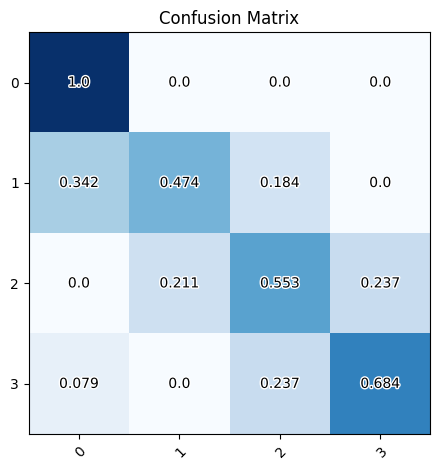

In [135]:
plot_confusion_matrix(val_dataloader, model)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/it]


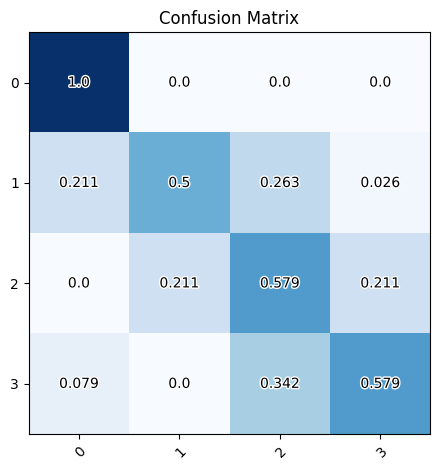

In [115]:
plot_confusion_matrix(val_dataloader, model)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.00s/it]


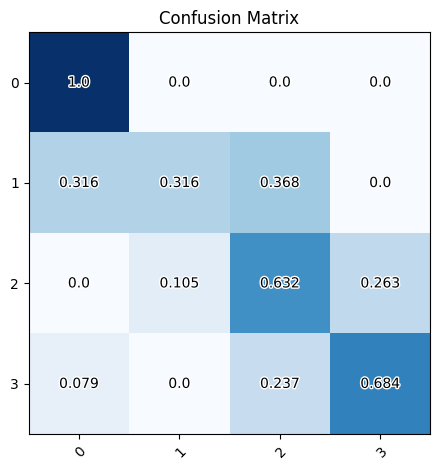

In [113]:
plot_confusion_matrix(val_dataloader, model)

In [310]:
# and another run again
# so: the evaluation on the test data is consistent when we don't do this resampling on the test dataloader.
run_eval_2(model, test_dataloader, runs=1)

# running the test again to see whether we get the same result.

torch.Size([42]) torch.Size([42])


tensor(0.5238)

In [185]:
# and another run again
run_eval_2(model, test_dataloader)

torch.Size([42]) torch.Size([42])


tensor(0.6429)

In [181]:
# and another run again
run_eval_2(model, test_dataloader)

torch.Size([42]) torch.Size([42])


tensor(0.6667)

In [178]:
# another run, for the ent map only.
# now lets get it going for 
run_eval_2(model, test_dataloader)

torch.Size([42]) torch.Size([42])


tensor(0.7619)

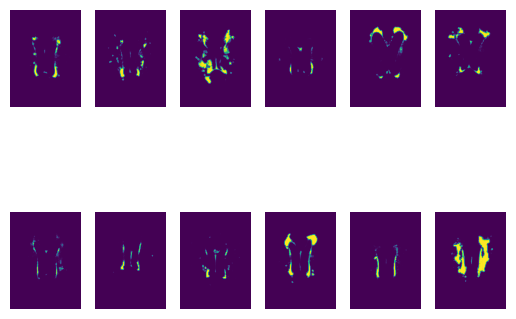

In [324]:
batch = next(iter(test_dataloader))
xs = batch[0][0]
for i in range(12):
    plt.subplot(2, 6, i+1)
    plt.imshow(xs[i][10])
    plt.axis('off')

In [ ]:
# get a plot of the first element of the batch (ensure it is ent and not pred)
# it is clearly overfitting here.
# shall we try rebalancing and ema here?
# what to do about the overfitting...

In [72]:
# check checkpoint changes, (this folder, target, split, run
# switch to doing eval on train val and test.
# plot a batch of the dataset, middle slice

100%|███████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.87it/s]


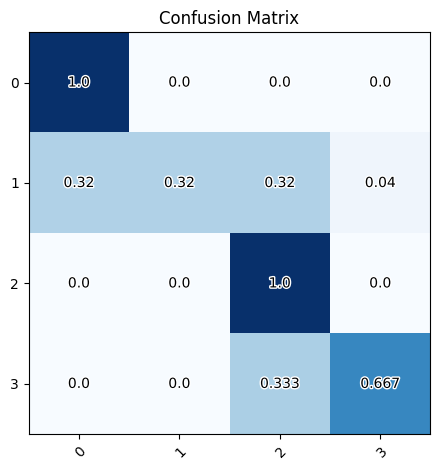

In [309]:
# another run
# it is converging to two very very different places, which I do NOT like so much
plot_confusion_matrix(test_dataloader, model)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.12it/s]


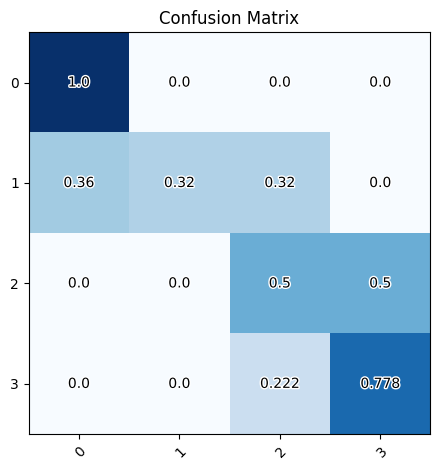

In [233]:
plot_confusion_matrix(test_dataloader, model)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s]


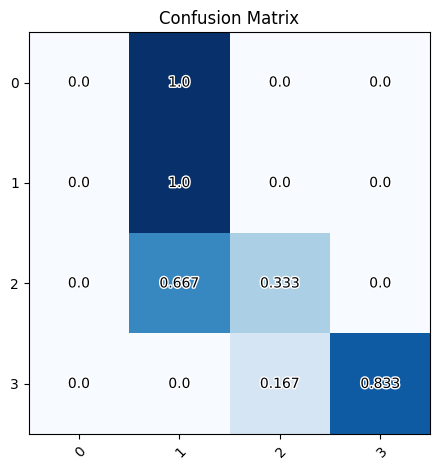

In [194]:
plot_confusion_matrix(val_dataloader, model)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:14<00:00,  1.06it/s]


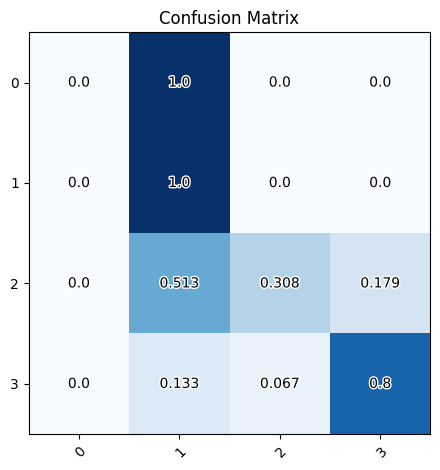

In [195]:
plot_confusion_matrix(train_dataloader, model)